In [11]:
f_s = 10e6;
T_s = 1/f_s;

n_fft = 2^18;
n_ini = 0;
k = 41;

f_i = f_s/n_fft*k;
a_i = 1;
b_i = 0;

n_i = 1e-4;

t = 0:T_s:T_s*(n_fft+n_ini-1);
y = a_i*sin.(2*pi*f_i*t) + b_i + n_i*randn(size(t));

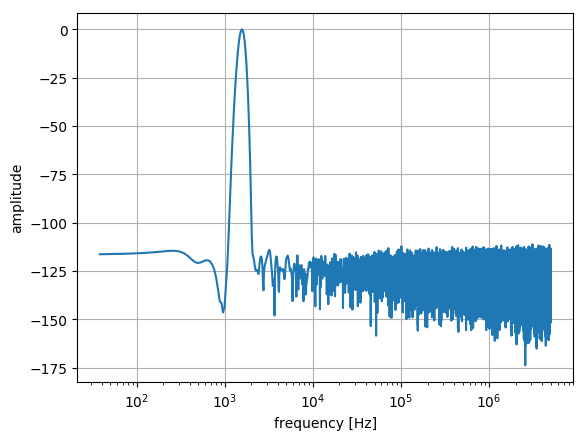

In [12]:
import DSP

w = DSP.Windows.kaiser(n_fft, 20);
wf = sum(w)/n_fft;
Y = fft(y.*w)/n_fft/wf;

f = linspace(0, f_s/2, (n_fft/2+1));

import PyPlot

PyPlot.semilogx(f, 20*log10.(2*abs.(Y[1:trunc(Int64, n_fft/2+1)])));
PyPlot.grid(true);
PyPlot.xlabel("frequency [Hz]");
PyPlot.ylabel("amplitude");

In [13]:
import DSP

function snr_iq(y, f_i, f_bw)
    n   = length(y);
    nbw = trunc(Int64, n*f_bw);
    
    xs = sin.(2*pi*f_i*(1:n));
    xc = cos.(2*pi*f_i*(1:n));
    a  = sum(2*xs.*y)/n;
    b  = sum(2*xc.*y)/n;

    i_sig = (a*xs+b*xc);
    i_noi = y - i_sig;
    
    w     = DSP.Windows.hanning(n);
    wf    = sum(w.^2)/n;
    wfa   = sum(w)/n;

    I_sig = fft(i_sig.*w)/n;
    I_noi = fft(i_noi.*w)/n;
    
    P_sig = sum(abs.(I_sig[1:nbw]).^2);
    P_noi = sum(abs.(I_noi[1:nbw]).^2);
    
    10*log10(P_sig/P_noi)
end

function snr_kaiser(y, f_i, f_bw, f_s)
    n = length(y);

    sig_bin  = f_i/f_s*n;
    bw_bin = f_bw/f_s*n;
    sig_bins = (sig_bin-14:1:sig_bin+16);
    noi_bins = vcat(1:sig_bin-15, sig_bin+17:bw_bin);

    w = DSP.Windows.kaiser(n, 20);
    wf    = sum(w.^2)/n;
    Y = fft(y.*w)/n;
    P_sig = sum(abs.(Y[trunc.(Int64, sig_bins)]).^2);
    P_noi = sum(abs.(Y[trunc.(Int64, noi_bins)]).^2);
    
    10*log10(P_sig/P_noi)
end

function snr(y, f_i, f_bw, f_s)
    # snr_iq(y, f_i/f_s, f_bw/f_s);
    snr_kaiser(y, f_i, f_bw, f_s);
end

println(snr_iq(y, f_i/f_s, f_s/(2*f_s)))
println(snr_kaiser(y, f_i, f_s/2, f_s))

77.0228275109548
77.07033189316599


In [14]:
f_bw_sw = logspace(log10(f_s/(2*500)), log10(f_s/2), 20)
snr_bw_sw = zeros(20);

for (i, f_bw) in enumerate(f_bw_sw)
    snr_bw_sw[i] = snr(y, f_i, f_bw, f_s);
end

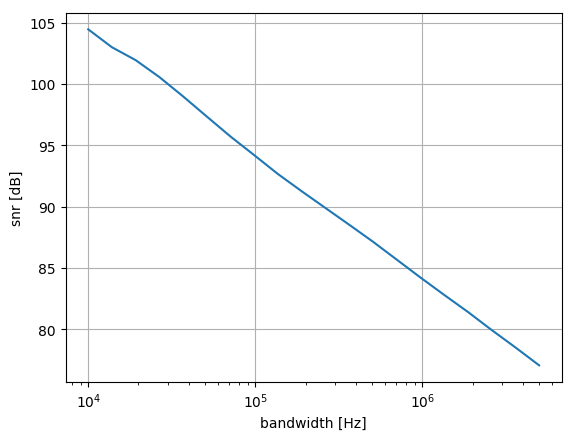

In [15]:
PyPlot.semilogx(f_bw_sw, snr_bw_sw);
PyPlot.xlabel("bandwidth [Hz]");
PyPlot.ylabel("snr [dB]");
PyPlot.grid();